In [2]:
import numpy as np                    # Biblioteca para manipulação númerica
import matplotlib.pyplot as plt       # Biblioteca para visualização e gráficos
import math                           # Biblioteca com funções matemáticas
import scipy as st
from scipy.odr import *
from scipy import interpolate
from scipy import optimize
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [3]:
def f2(x,y):
  der = []
  for i in range(2,len(x)-2,1):
    der.append((y[i+2]+y[i-2]-2*y[i])/((x[i+1]-x[i-1])**2))
  return der

In [4]:
'''
Coleta dos dados de fotometria.
'''

sh = gc.open_by_key("1SOZPPe9Z2OIChPyEEbToIPk-HXn6UW8QDEwILP7v7s0")

sheetList_data = sh.worksheets()
data = []

for sheet in sheetList_data:
  voltage = sheet.col_values(1)
  current = sheet.col_values(2)
  voltage.pop(0)
  current.pop(0)
  for x in enumerate(voltage):
    voltage[x[0]] = float(x[1])
  for y in enumerate(current):
    current[y[0]] = float(y[1])
  voltage = np.array(voltage)
  current = np.array(current)
  data.append([np.array(voltage),np.array(current),sheet.title])

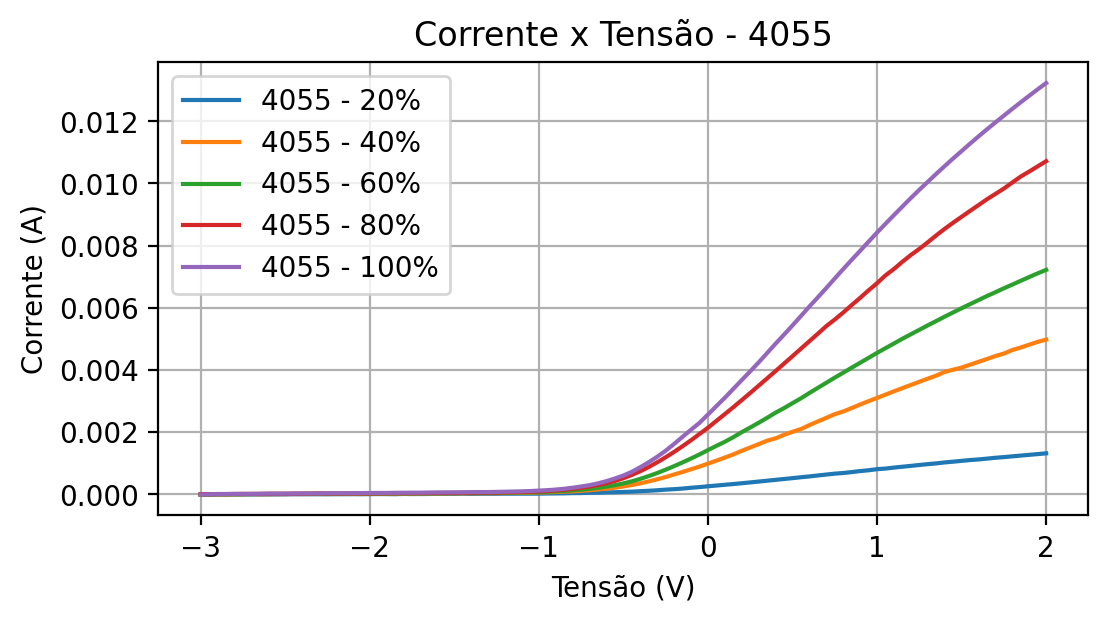

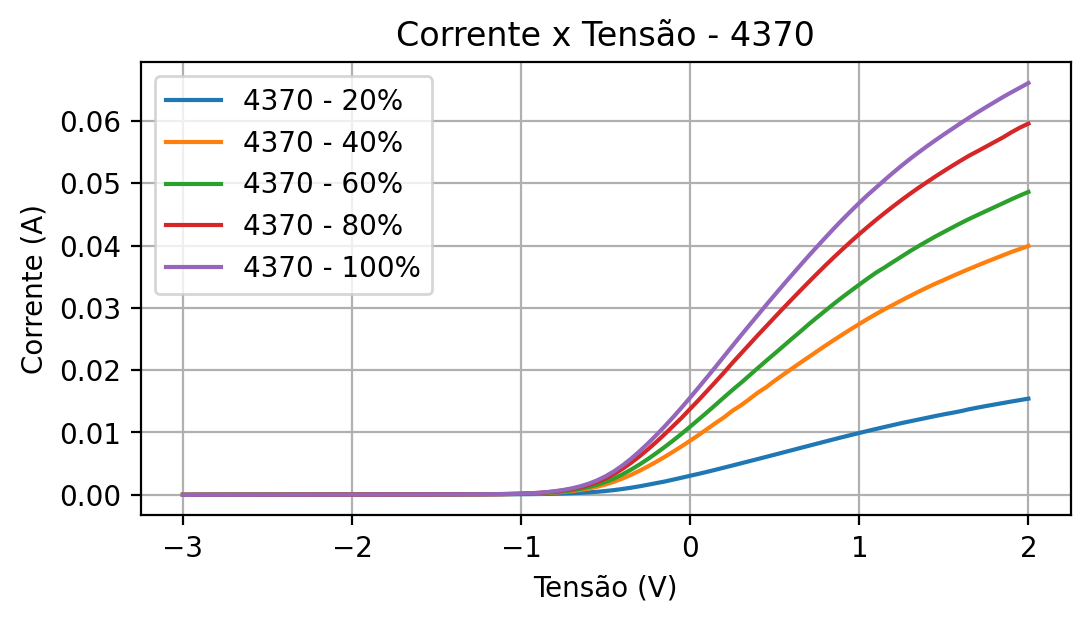

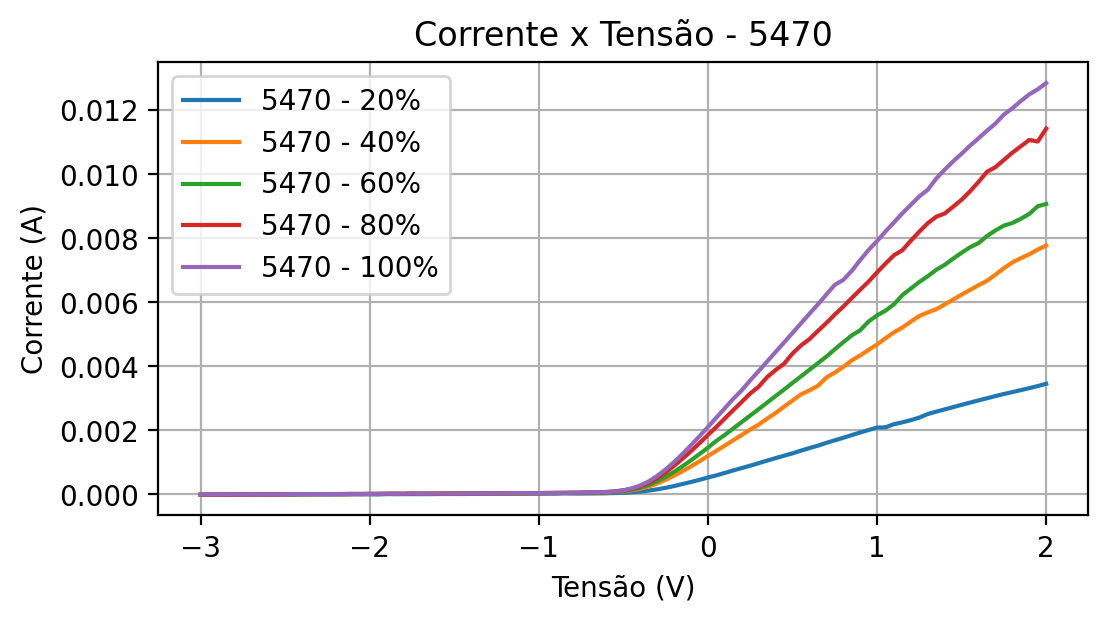

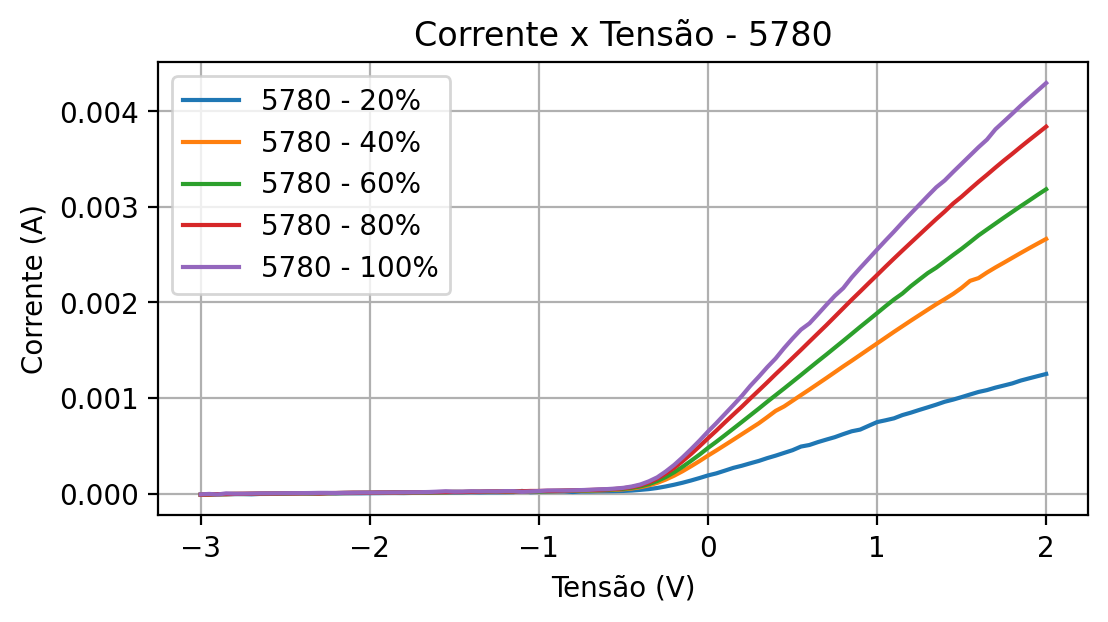

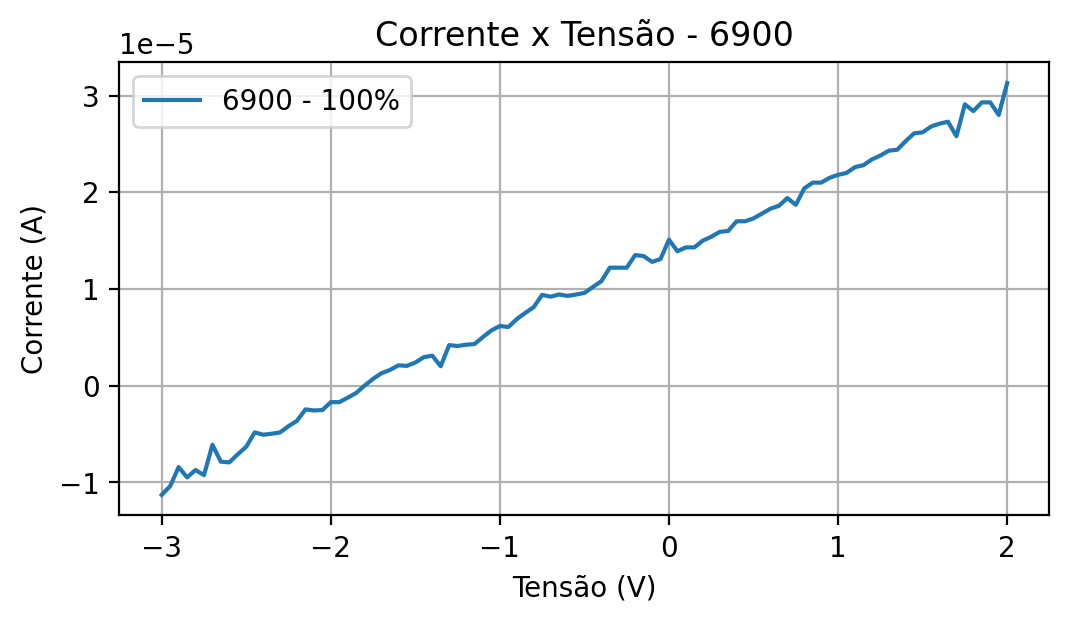

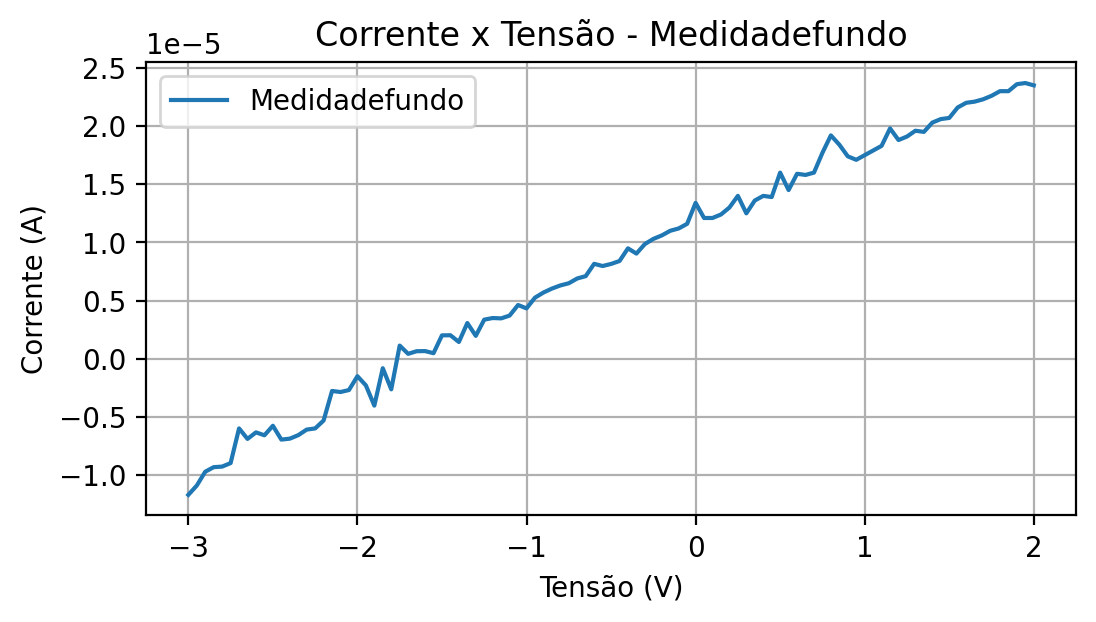

In [5]:
'''
Mude a variavel lbl para a cor desejada para plotar o grafico respectivo.
'''

lbl_list = ['4055','4370','5470','5780','6900','Medidadefundo']
for lbl in lbl_list:
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(6, 3), dpi=200)
    plt.title('Corrente x Tensão - '+lbl)
    plt.xlabel('Tensão (V)')
    plt.ylabel('Corrente (A)')
    for i in enumerate(data):
      if lbl in i[1][2]:
        plt.plot(i[1][0], i[1][1],"-",label=i[1][2])
    plt.grid(True,'both')
    plt.legend()
    plt.show()

In [6]:
def extractDigits(lst):
    res = []
    for el in lst:
        sub = el.split(', ')
        res.append(sub)
      
    return(res)

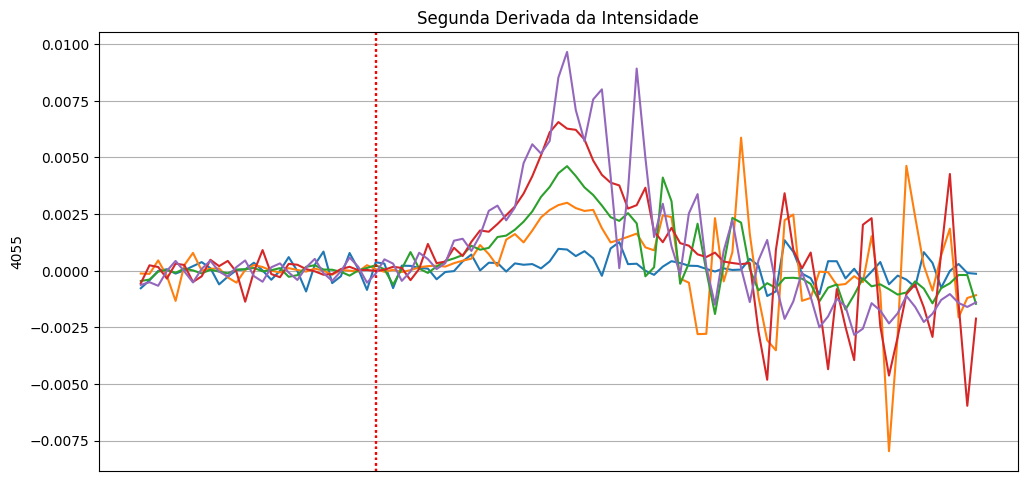

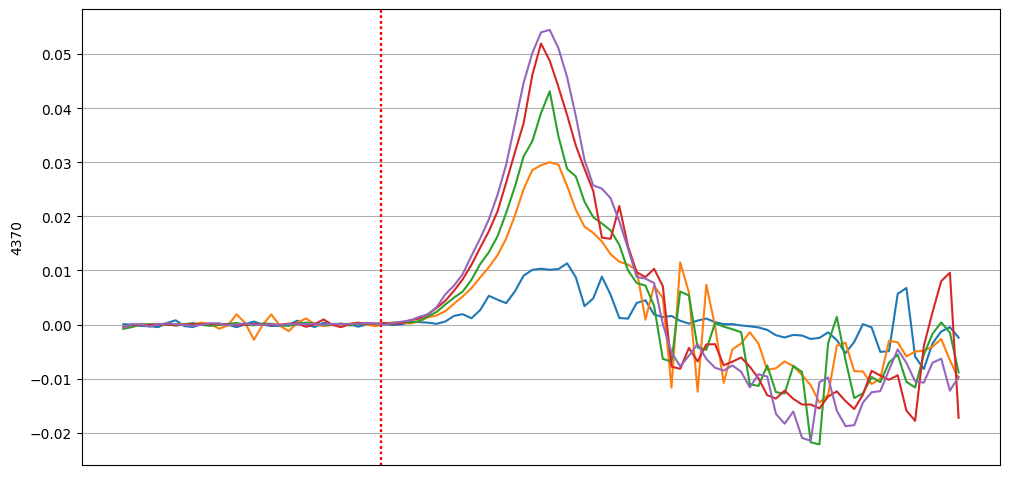

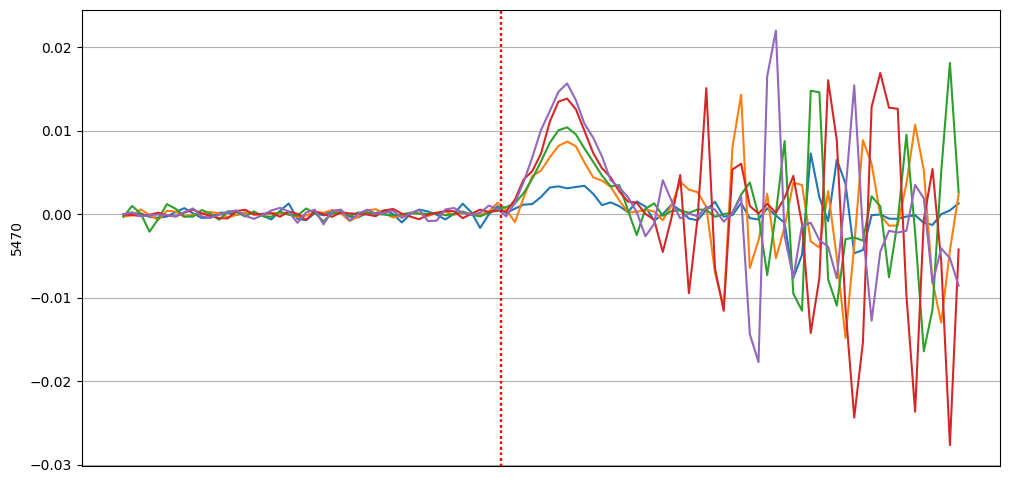

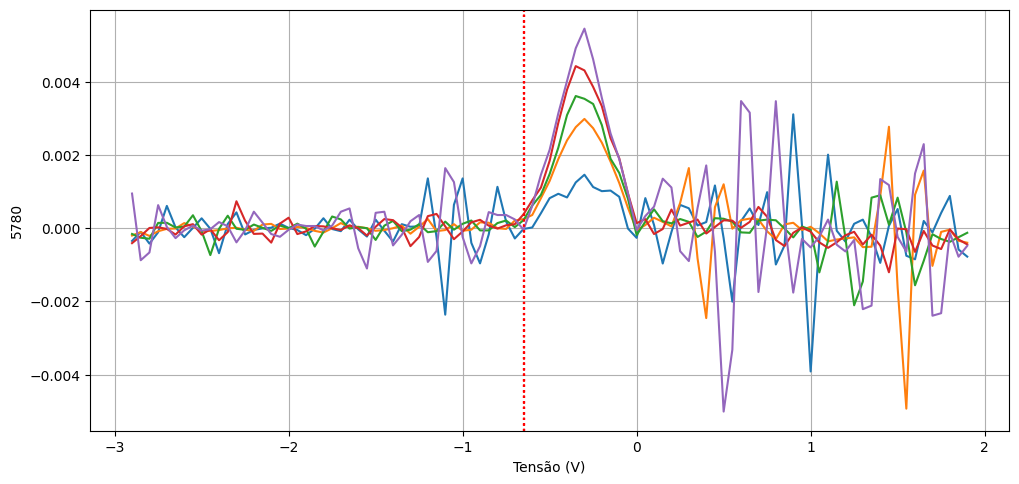

In [7]:
'''
Utilizando o método da segunda derivada para determinar o V0
'''
import pandas as pd

lbl_list = ['4055','4370','5470','5780']

for lbl in lbl_list:
  V0_voltage = [-1.55,-1.42,-0.73,-0.65]

  plt.rcParams['font.size'] = 10
  fig = plt.figure(figsize=(10,5), dpi=100)

  if lbl == lbl_list[0]:
    globals()['ax'+lbl] = fig.add_subplot()
  else: 
     globals()['ax'+lbl] = fig.add_subplot(sharex = globals()['ax'+ lbl_list[0]])

  if lbl == lbl_list[0]:
    globals()['ax'+lbl].set_title('Segunda Derivada da Intensidade')
    globals()['ax'+lbl].get_xaxis().set_visible(False)
  elif lbl == lbl_list[len(lbl_list)-1]:
    globals()['ax'+lbl].set_xlabel('Tensão (V)')
  else: 
    globals()['ax'+lbl].get_xaxis().set_visible(False)
  
  globals()['ax'+lbl].grid(True,'both')
  globals()['ax'+lbl].set_ylabel(lbl)
    
  
  fig.tight_layout()
 
  for i in enumerate(data):
    if lbl in i[1][2]:
      derivate = f2(i[1][0],i[1][1])
      globals()['ax'+lbl].plot(i[1][0][2:-2], derivate,"-")
      if lbl != '6900':
        globals()['ax'+lbl].axvline(x=V0_voltage[lbl_list.index(lbl)], color='r', linestyle=':')
  
  plt.grid(True,'both')
  plt.show()

In [8]:
def func_const(a,x):
  return a[0]*np.ones(np.size(x))

In [9]:
V0 = [[1.55, 1.42, 0.73, 0.65], [0.05, 0.05, 0.05, 0.05]]
  
#V0.append(list(map(int, lbl_list[0:4])))
#tá na planilha analise de frequência
frq = [7.40e14, 6.86e14, 5.49e14, 5.19e14]
V0.append(frq)
inc_frq = [1e13, 9e12, 6e12, 5e12]
V0.append(inc_frq)
print(V0)

[[1.55, 1.42, 0.73, 0.65], [0.05, 0.05, 0.05, 0.05], [740000000000000.0, 686000000000000.0, 549000000000000.0, 519000000000000.0], [10000000000000.0, 9000000000000.0, 6000000000000.0, 5000000000000.0]]


In [12]:
def func_linear(a,x):
  return a[0]*x + a[1]

Beta: [ 4.00458364e-15 -1.36000000e+00]
Beta Std Error: [6.5388758e-17 0.0000000e+00]
Beta Covariance: [[1.25868643e-29 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
Residual Variance: 0.0003396945865237568
Inverse Condition #: 1.0000000000000002
Reason(s) for Halting:
  Problem is not full rank at solution
  Parameter convergence
249713850218695.84


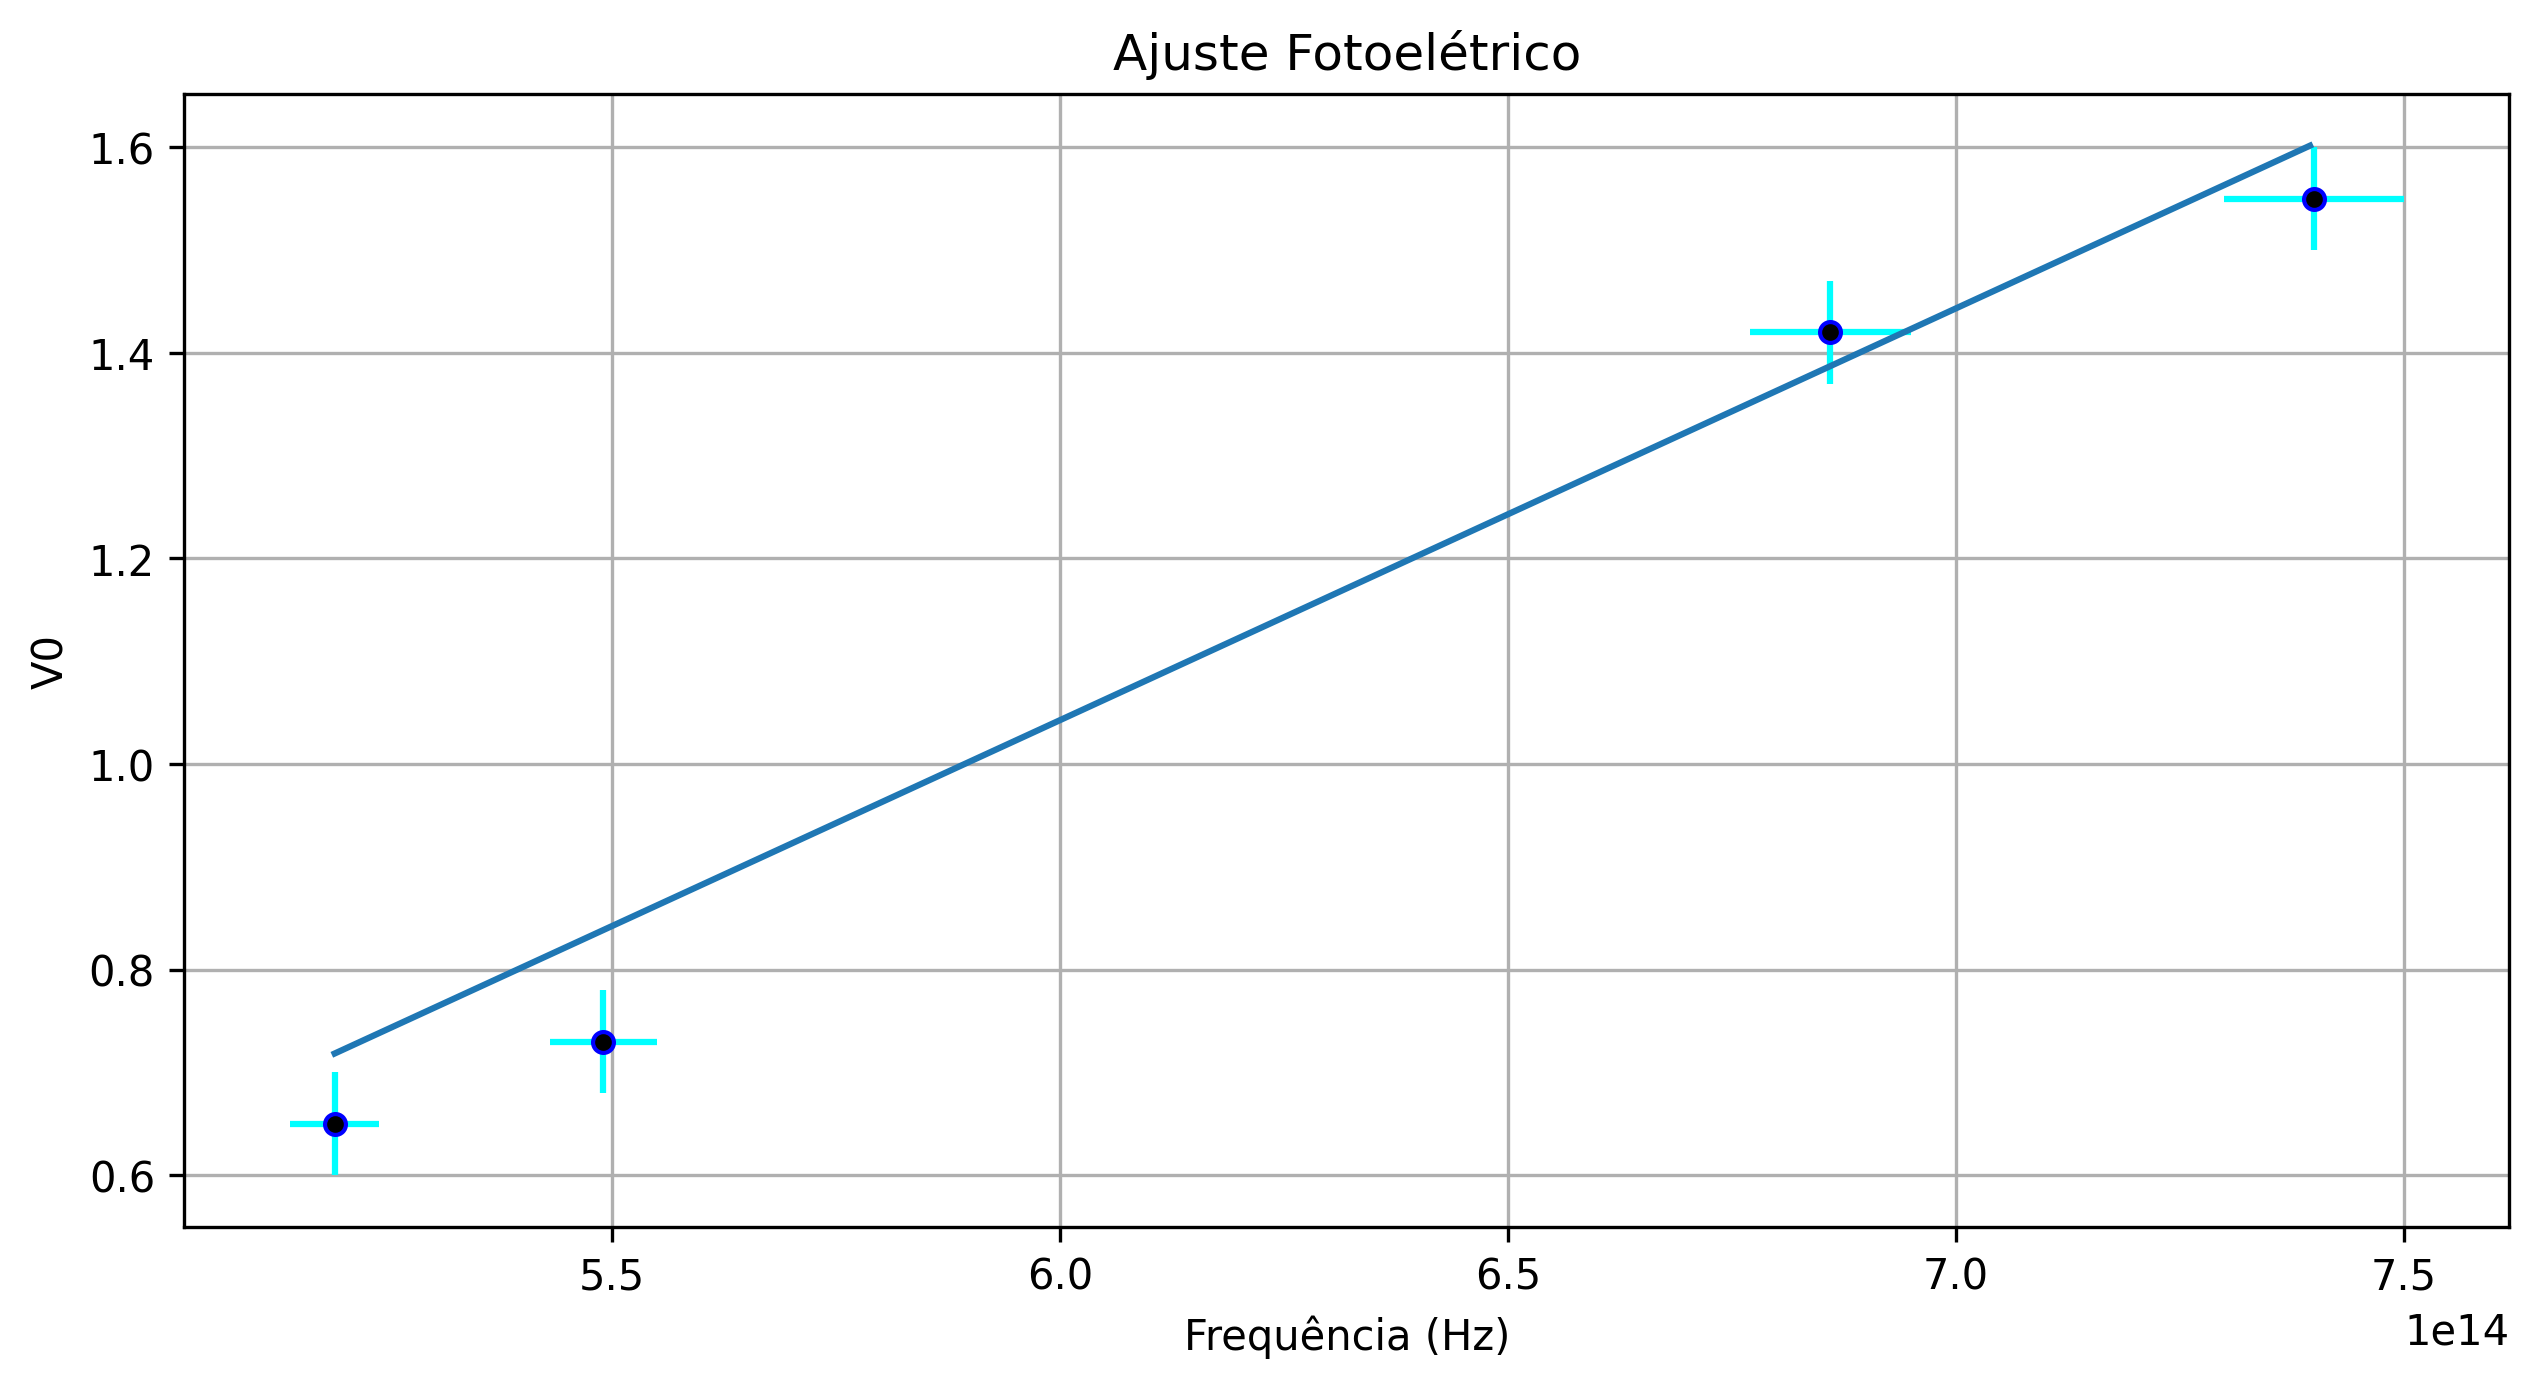

In [62]:
graphs = []
popt = []
param = []

V0_new = [[],[],[]]
x = V0[0]
y = V0[3]

for j in enumerate(V0[0]):
  V0_new[0].append(V0[0][j[0]])
  V0_new[1].append(V0[1][j[0]])
  V0_new[2].append(V0[2][j[0]])

steps = 500
f = Model(func_linear)
data = Data(frq, V0_new[0],wd=0,we=V0_new[1])
myodr = ODR(data, f, beta0=[1/4.1e-15,-1.36])
myoutput = myodr.run()
param.append([myoutput.beta,myoutput.sd_beta,myoutput.res_var])
myoutput.pprint()
start_a = frq[-1]
stop_a = frq[0]
size_a = (stop_a-start_a)/steps
X = np.zeros(steps)
Y = np.zeros(steps)
for u in range(steps):
    X[u] = start_a + (u*size_a)
    Y[u] = func_linear(myoutput.beta,(u*size_a)+start_a)
graph = [np.array(X),np.array(Y)]

print(1/myoutput.beta[0])

plt.rcParams['font.size'] = 10
plt.figure(figsize=(10, 5), dpi=300)
plt.title('Ajuste Fotoelétrico')
plt.xlabel('Frequência (Hz)')
plt.ylabel('V0')
plt.plot(frq, V0_new[0],".b" ,markersize=10)
plt.plot(X, Y,"-")
plt.grid(True,'both')
plt.errorbar(V0[2], V0[0], xerr= V0[3], yerr = V0[1],fmt='.',ecolor = 'cyan',color='black')
plt.show()

In [14]:
testet_planck = (3.93702853e-15 )/(4.99467979e-15/2)
testet_trabalho = (-1.36000000e+00  + 1.36 )/(0.0001e+00/2)
print(testet_planck)
print(testet_trabalho)

1.5764888623620856
0.0


testes que deram errado ---> desconsiderar 

In [42]:
%matplotlib inline
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [40]:
dic = {"V0":V0[0], "inc_V0":V0[1], "f":V0[2], "inc_f":V0[3]}
dados = pd.DataFrame(data=dic)
dados  

,V0,inc_V0,f,inc_f
0,1.55,0.05,7.400000e+14,1.000000e+13
1,1.42,0.05,6.860000e+14,9.000000e+12
2,0.73,0.05,5.490000e+14,6.000000e+12
3,0.65,0.05,5.190000e+14,5.000000e+12


In [56]:
Y = dados.V0
X = dados.f
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     V0   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                       inf
Date:                Sun, 22 May 2022   Prob (F-statistic):                nan
Time:                        16:02:23   Log-Likelihood:               0.042637
No. Observations:                   4   AIC:                             1.915
Df Residuals:                       3   BIC:                             1.301
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.824e-30   3.44e-31      8.205      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
